![tower_bridge](tower_bridge.jpg)

As the climate changes, predicting the weather becomes ever more important for businesses. You have been asked to support on a machine learning project with the aim of building a pipeline to predict the climate in London, England. Specifically, the model should predict mean temperature in degrees Celsius (°C).

Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `mlflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - **target** mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [34]:
# Run this cell to install mlflow
!pip install mlflow

Defaulting to user installation because normal site-packages is not writeable


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64
15341


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_tr,metrics.rmse_lr,metrics.rmse_fr,params.max_depth,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type
0,e8f9a31e687e4ce4a093e5cbeb481195,532353760619728262,FINISHED,file:///work/files/workspace/mlruns/5323537606...,2024-04-18 21:57:25.447000+00:00,2024-04-18 21:57:34.549000+00:00,3.590786,3.833712,2.926398,20,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""e8f9a31e687e4ce4a093e5cbeb481195""...",run_4,repl,LOCAL
1,101341e1ef0d423795c4e3476b0145b5,532353760619728262,FINISHED,file:///work/files/workspace/mlruns/5323537606...,2024-04-18 21:57:17.208000+00:00,2024-04-18 21:57:25.422000+00:00,2.925813,3.833712,2.767683,10,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""101341e1ef0d423795c4e3476b0145b5""...",run_3,repl,LOCAL
2,04efc509702d468f95ad22f42ba2ac13,532353760619728262,FINISHED,file:///work/files/workspace/mlruns/5323537606...,2024-04-18 21:57:09.387000+00:00,2024-04-18 21:57:17.184000+00:00,2.976504,3.833712,2.916417,5,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""04efc509702d468f95ad22f42ba2ac13""...",run_2,repl,LOCAL
3,9cdc3cc41ad24aa5856f657b8b3aebaf,532353760619728262,FINISHED,file:///work/files/workspace/mlruns/5323537606...,2024-04-18 21:57:01.787000+00:00,2024-04-18 21:57:09.363000+00:00,3.917318,3.833712,3.837694,2,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""9cdc3cc41ad24aa5856f657b8b3aebaf""...",run_1,repl,LOCAL
4,6c89993da63b4ac487dd078df89038be,532353760619728262,FINISHED,file:///work/files/workspace/mlruns/5323537606...,2024-04-18 21:56:54.307000+00:00,2024-04-18 21:57:01.763000+00:00,4.752035,3.833712,4.698522,1,/usr/lib/python3/dist-packages/python_kernel/k...,"[{""run_id"": ""6c89993da63b4ac487dd078df89038be""...",run_0,repl,LOCAL


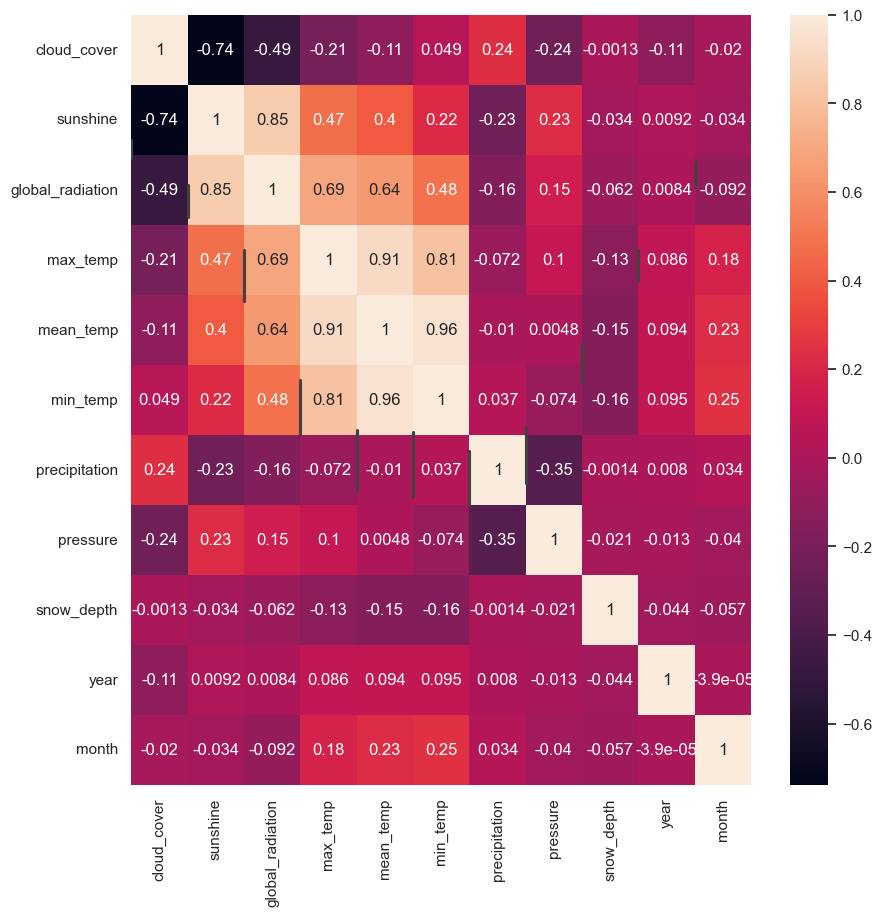

In [35]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

# Read in the data
weather = pd.read_csv("london_weather.csv")

# Show the first 5 rows
weather.head(5)

# Show info
weather.info()

# Parse date column to specified format
weather['date'] = pd.to_datetime(weather['date'],format="%Y%m%d")

# Check number of missing values
print(weather.isna().sum())
print(len(weather))

# Group data by year and month
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month

weather_per_month = weather.groupby(['year', 'month'], as_index=False).mean()

# Visualise mean temperature
sns.lineplot(x="year", y="mean_temp", data=weather_per_month)

# Visualise mean sunshine
sns.barplot(x="month", y="sunshine", data=weather_per_month)

# Visualise heatmap of correlation
sns.heatmap(weather.corr(), annot=True)

# Select features
weather_features = ["cloud_cover", "sunshine", "global_radiation", "snow_depth", "month", "mean_temp"]
weather = weather[weather_features]

# Process data into train and test sets
def preprocess_df(weather, weather_features, target_var):
    weather = weather.dropna(subset=[target_var])
    X = weather[weather_features]
    y = weather[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

weather_features = ['month', 'cloud_cover', 'sunshine', 'global_radiation', 'snow_depth']
target_var = 'mean_temp'
X_train, X_test, y_train, y_test = preprocess_df(weather, weather_features, target_var)


# Predict on the test set and evaluate performance
def predict_and_evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Create experiment
EXPERIMENT_NAME = 'weather_prediction3'
EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

# Setup for loop
for idx, depth in enumerate([1, 2, 5, 10, 20]):
    parameters = {
        'max_depth': depth,
        'random_state': 1
    }
    
    RUN_NAME = f"run_{idx}"
    # Create and log models
    with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=RUN_NAME):
        lin_reg = LinearRegression().fit(X_train, y_train)
        tree_reg = DecisionTreeRegressor(**parameters).fit(X_train, y_train)
        forest_reg = RandomForestRegressor(**parameters).fit(X_train, y_train)
        mlflow.sklearn.log_model(lin_reg, "lin_reg")
        mlflow.sklearn.log_model(tree_reg, "tree_reg")
        mlflow.sklearn.log_model(forest_reg, "forest_reg")
        lin_reg_rmse = predict_and_evaluate(lin_reg, X_test, y_test)
        tree_reg_rmse = predict_and_evaluate(tree_reg, X_test, y_test)
        forest_reg_rmse = predict_and_evaluate(forest_reg, X_test, y_test)
        
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_lr", lin_reg_rmse)
        mlflow.log_metric("rmse_tr", tree_reg_rmse)
        mlflow.log_metric("rmse_fr", forest_reg_rmse)

# Save results
        
experiment_results = mlflow.search_runs(experiment_names=[EXPERIMENT_NAME])
experiment_results



